In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
# from lightgbm import LGBMClassifier
from scipy import stats

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression, SGDRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.base import clone
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import MiniBatchKMeans

In [2]:
# Read in data from github
url_accident = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/accident.csv.gz?raw=tr"
url_vehicle = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/vehicle.csv.gz?raw=tr"
url_person = "https://github.com/BradenAnderson/Accident_Severity_Prediction/blob/main/Data/person.csv.gz?raw=tr"

accident = pd.read_csv(url_accident,compression='gzip')
vehicle = pd.read_csv(url_vehicle, compression='gzip', low_memory=False, encoding="ISO-8859-1")
person = pd.read_csv(url_person, compression='gzip', low_memory=False, encoding="ISO-8859-1")

In [3]:
# Filter accidents where driver is present and vehicle is involved
person = person.loc[(person.VEH_NO==1) & (person.PER_NO==1)]
vehicle = vehicle.loc[vehicle.VEH_NO==1]

# Left join person with vehicle and accident
# Duplicated CASENUM are dropped
df = person.merge(vehicle.drop_duplicates(subset=['CASENUM']), on='CASENUM', how='left')
df = df.merge(accident.drop_duplicates(subset=['CASENUM']),on='CASENUM',how='left')

# Comprehensive list of variables used in this analysis
# ORIGINAL features from lab 1 / EDA: regionname, urbanicityname, body_typname, makename, mod_yearname, vtrafwayname, vnum_lanname, vsurcondname, vtrafconname, 
                                # typ_intname, int_hwyname, weathername, wkdy_imname, reljct1_imname, lgtcon_imname, maxsev_imname, alchl_imname, age_im, sex_imname, trav_sp
# DERIVED features: hour_binned, speeding_status
# NEW features post-lab 1 / EDA: rest_usename, pcrash1_imname, weather_binned (binning of `weathername`), body_type_binned (binning of `body_typname`), int_binned (binning of `typ_intname`)
# DISCARDED features that were not useful: hour_imname (unnecessary with `hour_binned`), vspd_lim (unnecessary with `speeding_status`), makename (too many levels), wrk_zonename

df = df[['REGIONNAME','URBANICITYNAME','BODY_TYPNAME_x', 'MOD_YEARNAME_x','VTRAFWAYNAME','VNUM_LANNAME','VSURCONDNAME','VTRAFCONNAME','TYP_INTNAME','INT_HWYNAME','WEATHERNAME',
        'WKDY_IMNAME', 'RELJCT1_IMNAME','LGTCON_IMNAME','MAXSEV_IMNAME','ALCHL_IMNAME','AGE_IM','SEX_IMNAME','TRAV_SP','REST_USENAME','PCRASH1_IMNAME','HOUR_IMNAME','VSPD_LIM',
        'HOUR_IM']]

df = df.rename(columns=str.lower)
df.shape

(54473, 24)

In [4]:
# Remove NA values since they are low representation of the entire dataset
df.dropna(inplace=True)

# Remove unknown instances, convert to numeric dtype
non_int_values = pd.to_numeric(df.mod_yearname_x, errors='coerce').isna()
df = df[-non_int_values]
df['mod_yearname_x'] = pd.to_numeric(df['mod_yearname_x'])

# Filter to years 1980+
df = df.loc[df['mod_yearname_x'] >= 1980]

# trav_sp
# Speed Greater Than 151 mph indicated as 997
# Speed not reported indicated as 998
# Speed reported as unknown indicated as 999
# Discern number of rows lost if 997, 998, and 998 are removed
# 28975 !! Will impute instead
df.loc[df['trav_sp'] >= 997].shape[0]

# regionname
df.loc[:, "regionname"] = df.loc[:,"regionname"].apply(lambda string: string.split()[0])


# urbanicityname
df["urbanicityname"] = df.loc[:,"urbanicityname"].apply(lambda string: string.split()[0])

# Bin observations 'Not Reported', 'Reported as Unknown' into NR/UNK
df['vtrafwayname'] = df['vtrafwayname'].replace(['Not Reported', 'Reported as Unknown'], 'NR/UNK')

# Bin 'Not Reported', 'Reported as Unknown', 'Other' as NR/UNK/OTH
df['vsurcondname'] = df['vsurcondname'].replace(['Not Reported', 'Reported as Unknown', 'Other'], 'NR/UNK/OTH')

# Bin 'Not Reported', 'Other Regulatory Sign', 'Other', 'Reported as Unknown', 'Other Highway Traffic Signal', 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'
df['vtrafconname'] = df['vtrafconname'].replace(['Not Reported', 'Other Regulatory Sign', 'Other', 
                                                 'Reported as Unknown', 'Other Highway Traffic Signal', 
                                                 'Unknown Highway Traffic Signal', 'Unknown Regulatory Sign'], 'NR/UNK/OTH')

# Drop observations with Unknown
df.drop(df[df['int_hwyname'] == 'Unknown'].index, inplace = True)

In [5]:
def create_speeding_feature(row):
    
    # Speed greater than 151 mph, you're speeding
    if row["trav_sp"] == 997:
        return 'speeding'
    
    # If we know they were going 95 mph or faster, calling that speeding
    # regardless of what the speed limit is, or if we even know ths speed limit.
    elif row["trav_sp"] < 152 and row["trav_sp"] >= 95:
        return 'speeding'
    
    # If the speed limit is unknown, speeding is unknown
    elif row["vspd_lim"] == 98 or row["vspd_lim"] == 99:
        return 'unknown'
    
    # If the traveling speed is unknown, speeding is unknown
    elif row['trav_sp'] == 998 or row['trav_sp'] == 999:
        return 'unknown'
    
    # If traveling faster than the speed limit, speeding
    elif row['trav_sp'] > row['vspd_lim']:
        return 'speeding'
    else:
        return 'not speeding'
    
df["speeding_status"] = df.apply(lambda row: create_speeding_feature(row), axis='columns')

def create_binned_hours_feature(numeric_hour, night_hours=[0,1,2,3,4,21,22,23], morning_hours=[5,6,7,8,9,10,11], 
                                afternoon_hours=[12,13,14,15], evening_hours=[16,17,18,19,20]):
    
    # NOTE: numeric_hour is a value from the HOUR_IM column

    # Default for night is 9pm-4:59am
    if numeric_hour in night_hours:
        return "Night"
    
    # Default for morning is 5am-11:59am
    elif numeric_hour in morning_hours:
        return "Morning"
    
    # Default for Afternoon is 12:00pm-3:59pm
    elif numeric_hour in afternoon_hours:
        return "Afternoon"
    
    # Default for evening is 4:00pm-8:59pm
    elif numeric_hour in evening_hours:
        return "Evening"
    
df["hour_binned"] = df["hour_im"].apply(lambda hour: create_binned_hours_feature(numeric_hour=hour))

# After hour_im is used to create hour_binned, we no longer need hour_im
df.drop(columns="hour_im", inplace=True)

In [6]:
df['body_type_binned']=df['body_typname_x']

df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['4-door sedan, hardtop',
                                       '2-door sedan,hardtop,coupe',
                                       '3-door coupe','Sedan/Hardtop, number of doors unknown'
                                        ],value=1)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        'Compact Utility (Utility Vehicle Categories \"Small" and \"Midsize\")',
                                         value=2)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                                      ["Auto-based pickup (includes E1 Camino, Caballero, Ranchero, SSR, G8-ST, Subaru Brat, Rabbit Pickup)",
                                        "Light Pickup",
                                        "Unknown (pickup style) light conventional truck type",
                                        "Unknown light truck type",
                                        "Unknown light vehicle type (automobile,utility vehicle, van, or light truck)",
                                        'Light Vehicle Based Motor Home (chassis mounted)'
                                        ],value=3)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                         ['Large utility (ANSI D16.1 Utility Vehicle Categories and "Full Size" and "Large")',
                                        'Utility Vehicle, Unknown body type'
                                         ],value=4)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['ATV/ATC [All-Terrain Cycle]',
                                        'Moped or motorized bicycle',
                                        'Motor Scooter',
                                        'Off-road Motorcycle',
                                        'Other motored cycle type (mini-bikes, pocket motorcycles "pocket bikes")',
                                        'Three-wheel Motorcycle (2 Rear Wheels)',
                                        'Two Wheel Motorcycle (excluding motor scooters)',
                                        'Unenclosed Three Wheel Motorcycle / Unenclosed Autocycle (1 Rear Wheel)',
                                        'Unknown motored cycle type',
                                        'Unknown Three Wheel Motorcycle Type'
                                        ],value=5)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Station Wagon (excluding van and truck based)',
                                        'Utility station wagon (includes suburban limousines, Suburban, Travellall, Grand Wagoneer)'
                                        ],value=6)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['3-door/2-door hatchback',
                                        '5-door/4-door hatchback',
                                        'Hatchback, number of doors unknown'
                                        ],value=7)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Cross Country/Intercity Bus',
                                        'Medium/Heavy Vehicle Based Motor Home',
                                        'Other Bus Type',
                                        'School Bus',
                                        'Transit Bus (City Bus)',
                                        'Unknown Bus Type'
                                        ],value=8)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Cab Chassis Based (includes Rescue Vehicle, Light Stake, Dump, and Tow Truck)',
                                        'Medium/heavy Pickup (GVWR greater than 10,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR greater than 26,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR range 10,001 to 19,500 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR range 19,501 to 26,000 lbs.)',
                                        'Single-unit straight truck or Cab-Chassis (GVWR unknown)',
                                        'Truck-tractor (Cab only, or with any number of trailing unit; any weight)',
                                        'Unknown if single-unit or combination unit Heavy Truck (GVWR greater than 26,000 lbs.)',
                                        'Unknown if single-unit or combination unit Medium Truck (GVWR range 10,001 lbs. to 26,000 lbs.)',
                                        'Unknown medium/heavy truck type'
                                         ],value=9)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        'Convertible(excludes sun-roof,t-bar)',
                                           value=10)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Large Van-Includes van-based buses (B150-B350, Sportsman, Royal Maxiwagon, Ram, Tradesman,...)',
                                        'Minivan (Chrysler Town and Country, Caravan, Grand Caravan, Voyager, Voyager, Honda-Odyssey, ...)',
                                        'Other van type (Hi-Cube Van, Kary)',
                                        'Step van (GVWR greater than 10,000 lbs.)',
                                        'Step-van or walk-in van (GVWR less than or equal to 10,000 lbs.)',
                                        'Unknown van type',
                                        'Van-Based Bus GVWR greater than 10,000 lbs.'
                                        ],value=11)
df['body_type_binned']=df['body_type_binned'].replace(to_replace=
                                        ['Construction equipment other than trucks (includes graders)',
                                        'Farm equipment other than trucks',
                                        'Golf Cart',
                                        'Large Limousine-more than four side doors or stretched chassis',
                                        'Low Speed Vehicle (LSV) / Neighborhood Electric Vehicle (NEV)',
                                        'Not Reported',
                                        'Other or Unknown automobile type',
                                        'Other vehicle type (includes go-cart, fork-lift, city street sweeper dunes/swamp buggy)',
                                        'Recreational Off-Highway Vehicle',
                                        'Unknown body type',
                                        'Unknown truck type (light/medium/heavy)',
                                        ],value=12)


df['body_type_binned'] = df['body_type_binned'].astype(str)

##drop original column after binning
df.drop(columns='body_typname_x', inplace=True)

In [7]:
def intersection_category(row):
    if row == 'Not an Intersection':
        result = 'No'
    elif row == 'Reported as Unknown':
        result = 'Other'
    elif row == 'Not Reported':
        result = 'Other'
    else:
        result = 'Yes'
    return result

df['intersection_binned'] = df['typ_intname'].apply(intersection_category)


In [8]:
def weather_cat(row):
    if row == 'Cloudy':
        return 'Not Clear'
    elif row == 'Fog, Smog, Smoke':
        return 'Not Clear' 
    elif row == 'Snow':
        return 'Wintery'
    elif row == 'Blowing Snow':
        return 'Wintery'
    elif row == 'Sleet or Hail':
        return 'Wintery'
    elif row == 'Freezing Rain or Drizzle':
        return 'Wintery'
    elif row == 'Severe Crosswinds':
        return 'Windy'
    elif row == 'Blowing Sand, Soil, Dirt':
        return 'Windy'
    elif row == 'Clear':
        return 'Clear'
    elif row == 'Rain':
        return 'Rain'
    else:
        return 'Other'
df['weather_binned'] = df['weathername'].apply(weather_cat)

In [9]:
# rest_use: bin into none, minimal, full, other
def restraint_category(row):
    if row == 'Shoulder and Lap Belt Used':
        result = 'Full'
    elif row == 'None Used/Not Applicable':
        result = 'None'    
    elif row == 'Lap Belt Only Used':
        result = 'Minimal'
    elif row == 'Shoulder Belt Only Used':
        result = 'Minimal'
    elif row == 'Restraint Used - Type Unknown':
        result = 'Minimal'
    else:
        result = 'Other'
    return result

df['restraint_binned'] = df['rest_usename'].apply(restraint_category)

In [10]:
# Remove Injured, Severity Unknown and Died Prior to Crash 
remove = ['Injured, Severity Unknown', 'Died Prior to Crash*']
df = df[df.maxsev_imname.isin(remove) == False]
df['maxsev_imname'] = df['maxsev_imname'].str[:-4]


In [11]:
# Combine No Apparent Injury, Possible Injury, Suspected Minor Injury into one bin
# Combine Suspected Serious Injury and Fatal Injury into one bin
df['maxsev_binned'] = df['maxsev_imname'].replace(to_replace={'Suspected Serious Injury':'Fatal', 
                                                              'Fatal Injury':'Fatal', 
                                                              'No Apparent Injury':'Not Fatal', 
                                                              'Possible Injury':'Not Fatal', 
                                                              'Suspected Minor Injury':'Not Fatal'})

In [12]:
df = df[df.columns.difference(['body_typname_x', 'typ_intname', 'weathername', 'rest_usename', 'hour_imname', 'vspd_lim'])]

In [13]:
# Split data 80/20 train test with 10 fold stratified cross validation
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["maxsev_binned"])

# instantiate the scaler
scaler = StandardScaler()

# Fit the scaler on the training set age and model year columns, and transform (scale) the training set age and model year columns
train_df.loc[:, ["age_im", "mod_yearname_x"]] = scaler.fit_transform(X=train_df.loc[:, ["age_im", "mod_yearname_x"]])

# Using means and standard deviations from training set, scale the test set
test_df.loc[:, ["age_im", "mod_yearname_x"]] = scaler.transform(X=test_df.loc[:, ["age_im", "mod_yearname_x"]])

In [14]:
# List of features to OneHotEncode
features_to_ohe = ["hour_binned", "intersection_binned", "lgtcon_imname", "pcrash1_imname", "regionname", 
                   "restraint_binned", "vtrafconname", "vtrafwayname", "weather_binned", "wkdy_imname", 
                   "vnum_lanname", "vsurcondname", "speeding_status", "body_type_binned"]

# Features that need to become binary
binary_features = ["urbanicityname", "alchl_imname", "reljct1_imname", "int_hwyname", "sex_imname"]

# List of all the features that are not being converted to binary, or being OneHotEncoder
# (Just a list of all features not in either of the two lists above).
non_encoded_features = [col for col in df.columns if col not in features_to_ohe + binary_features]

# Map each soon to be binary feature to its two initial values
binary_encoding_map = {feature:df[feature].unique().tolist() for feature in binary_features}

# Instantiate the OrdinalEncoder that will create the binary columns
ord_encoder = OrdinalEncoder(categories=[value for value in binary_encoding_map.values()])

# Map each feature that will be OneHotEncoded to a list of all possible categories that feature can take on. 
oridnal_encoding_map = {feature:df[feature].unique().tolist() for feature in features_to_ohe}

# Instantiate the OneHotEncoder, telling it what the possible categories are for each feature.
oh_encoder = OneHotEncoder(categories=[value for value in oridnal_encoding_map.values()]) 

encoders = ColumnTransformer(transformers=[("ordinal_encoder", ord_encoder, binary_features), 
                                           ("one_hot_encoder", oh_encoder, features_to_ohe)], 
                             remainder="passthrough",
                             sparse_threshold=0,
                             n_jobs=-1)

# Create a dataframe of all the encoded columns in the training set
train_encoded_features = pd.DataFrame(encoders.fit_transform(train_df.drop(columns=non_encoded_features)), 
                                      columns=encoders.get_feature_names_out())

# Remove the non-encoded versions, and add in the encoded-versions of all columns.
# Creates a version of the training set where all columns that need to be encoded are now encoded.
train_encoded_df = pd.concat(objs=[train_df.drop(columns=features_to_ohe+binary_features).reset_index(drop=True), 
                                   train_encoded_features.reset_index(drop=True)], 
                             axis='columns')

# Create a dataframe of all encoded (one hot and ordinal) columns for the test set
test_encoded_features = pd.DataFrame(encoders.transform(test_df.drop(columns=non_encoded_features)), 
                                     columns=encoders.get_feature_names_out())

# Remove the non-encoded versions, and add in the encoded-versions of all columns.
# Creates a version of the test set where all columns that need to be encoded are now encoded.
test_encoded_df = pd.concat(objs=[test_df.drop(columns=features_to_ohe+binary_features).reset_index(drop=True), 
                                   test_encoded_features.reset_index(drop=True)], 
                             axis='columns')

In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Set the placeholder values (which need to be imputed) to NaN
train_encoded_df.loc[train_encoded_df["trav_sp"].isin([997, 998, 999]), "trav_sp"] = np.nan
test_encoded_df.loc[test_encoded_df["trav_sp"].isin([997, 998, 999]), "trav_sp"] = np.nan

# Set up version of training dataset to be used for imputing trav_sp
imputer_train_df = train_encoded_df.copy(deep=True)
imputer_train_df.drop(columns=["maxsev_binned"], inplace=True)
severity_ord_enc = OrdinalEncoder(categories=[["No Apparent Injury", "Possible Injury", "Suspected Minor Injury", "Suspected Serious Injury", "Fatal Injury"]])
imputer_train_df["maxsev_imname"] = severity_ord_enc.fit_transform(X=imputer_train_df["maxsev_imname"].to_numpy().reshape(-1,1))

# Setting the minimum and maximum value the imputer can impute for a traveling speed. 
min_trav_sp = 15
max_trav_sp = 151
impute_min_values = [-np.inf if col != "trav_sp" else min_trav_sp for col in imputer_train_df.columns]
impute_max_values = [np.inf if col != "trav_sp" else max_trav_sp for col in imputer_train_df.columns]

# Instantiate the iterative imputer
imputer = IterativeImputer(min_value=impute_min_values, 
                           max_value=impute_max_values,
                           random_state=42)

# Fit the iterative imputer on the training set, and impute the training set
imputer_train_result = imputer.fit_transform(X=imputer_train_df)

# Take the output of running iteratrive imputer on the train set, and convert it to a dataframe
# Save the imputed version of traveling speed to train_encoded_df
imputer_train_result_df = pd.DataFrame(imputer_train_result, 
                                       columns=imputer.get_feature_names_out())
train_encoded_df["trav_sp_imputed"] = imputer_train_result_df["trav_sp"]

# Set up the version of the test dataset that will run through the imputer
imputer_test_df = test_encoded_df.copy(deep=True)
imputer_test_df.drop(columns=["maxsev_binned"], inplace=True)
imputer_test_df["maxsev_imname"] = severity_ord_enc.transform(X=imputer_test_df["maxsev_imname"].to_numpy().reshape(-1,1))

# Run the test data through the imputer
imputer_test_result = imputer.transform(X=imputer_test_df)

# Convert the output of running the test data through iterative imputer to a dataframe
imputer_test_result_df = pd.DataFrame(imputer_test_result, 
                                      columns=imputer.get_feature_names_out())
test_encoded_df["trav_sp_imputed"] = imputer_test_result_df["trav_sp"]

In [16]:
# Remove maxsev_imname from all dataframes
df.drop(columns="maxsev_imname", inplace=True)

# Dropping the Non-Imputed versions of travel speed, now that imputation has been performed
train_imputed_df = train_encoded_df.drop(columns=["trav_sp", "maxsev_imname"])
test_imputed_df = test_encoded_df.drop(columns=["trav_sp", "maxsev_imname"])

In [17]:
speed_scaler = StandardScaler()

# Fit and transform the scaler on the training set
train_imputed_df["trav_sp_scaled"] = speed_scaler.fit_transform(train_imputed_df["trav_sp_imputed"].to_numpy().reshape(-1,1))

# Only transform on the test set (no data leakage)
test_imputed_df["trav_sp_scaled"] = speed_scaler.transform(test_imputed_df["trav_sp_imputed"].to_numpy().reshape(-1,1))

# Use these dataframes moving forward
# The final, fully preprocessed dataframes (all features encoded and imputed as needed)
# Using "pp" to stand for preprocessed
train_pp_df = train_imputed_df.drop(columns="trav_sp_imputed")
test_pp_df = test_imputed_df.drop(columns="trav_sp_imputed")

In [18]:
train_df["trav_sp_scaled"] = train_pp_df.trav_sp_scaled.to_numpy()

## Modeling and Evaluation 1

In this section, we will search for optimal hyperparameters in both the KMeans Algorithm and MiniBatch KMeans for clustering on the continuous variables Travel Speed, Age of Driver and Age of Car

> For KMeans, there are three hyperparameters being tuned:
>> 1. The centroid initializers (k-means++ or random)
>>2. The number of times the algorithm is run with different centroid seeds
>>3. The number of clusters.

>For MiniBatch KMeans, there are three hyperparameters being tuned:
>>1. The centroid initalizers (k-means++ or random)
>>2. The number of batches for each run
>>3. The number of clusters.

> For both algorithms, we will use Inertia as the metric for evaluation and comparing in Modeling and Evaluation 2

In [19]:
x=train_pp_df.drop("maxsev_binned",axis=1)
#xx=train_pp_df[['age_im','mod_yearname_x',"maxsev_binned"]] trav_sp
xx=train_df[['mod_yearname_x','age_im','trav_sp_scaled']]

In [22]:
%%capture minibatch_kmean_time
%%time

##Mini Batch KMeans
import warnings
warnings.filterwarnings("ignore")
kmini_intertias = [] 
inits=['k-means++', 'random']
batch=[1024,1500,3000,8000]
for i in range(2, 30):
    for x in inits:
        for y in batch:
            kmeans_mini = MiniBatchKMeans(n_clusters = i, random_state =42,init=x,batch_size=y)
            kmeans_mini.fit(xx)
            temp=[i,x,kmeans_mini.inertia_,y]
            kmini_intertias.append(temp)
kmini_inertias=pd.DataFrame(kmini_intertias,columns=['n_clusters','init','inertia','batch'])    


In [23]:
%%capture kmean_time
%%time

##Tuning KMeans Hyperparameters
from sklearn.cluster import KMeans
kmeans_inertia=[]
inits=['k-means++', 'random']
n_inits=[10,50]
for i in range(1,30):
    for x in inits:
        for y in n_inits:
            K_means=KMeans(n_clusters=i,random_state=42,init=x,n_init=y)
            K_means.fit(xx)
            temp=[i,x,y,K_means.inertia_]
            kmeans_inertia.append(temp)
kmeans_inertia=pd.DataFrame(kmeans_inertia,columns=['n_clusters','init','n_init','inertia'])

>>### These are the results from the tail of the dataframes storing the hyperparameter tunings:


In [24]:
from IPython.display import display_html
print(" KMeans:",kmean_time,"\n","MiniBatch KMeans:",minibatch_kmean_time )
css_kmeans = kmeans_inertia.tail(n=10).style.set_table_attributes("style='display:inline'").set_caption('KMeans')
css_mini = kmini_inertias.tail(n=10).style.set_table_attributes("style='display:inline'").set_caption('MiniBatch KMeans')
 
display_html(css_kmeans._repr_html_()+css_mini._repr_html_(), raw=True)

 KMeans: Wall time: 3min 13s
 
 MiniBatch KMeans: Wall time: 45.2 s



,n_clusters,init,n_init,inertia
106,27,random,10,15869.480002
107,27,random,50,15792.277036
108,28,k-means++,10,15511.447561
109,28,k-means++,50,15449.014519
110,28,random,10,15388.545074
111,28,random,50,15388.545074
112,29,k-means++,10,15119.044003
113,29,k-means++,50,15059.439015
114,29,random,10,15097.290559
115,29,random,50,15049.486696


## Modeling and Evaluation 2

> Now that we have our metric of Inertia for the various hyperparameter tunings, we will plot each one against the other below.  Discussion of the graphs will follow.

<Figure size 432x288 with 0 Axes>

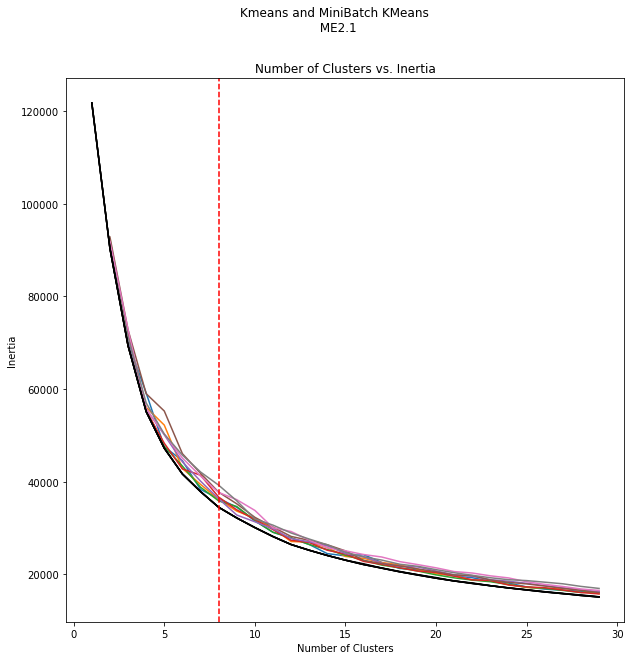

----------------------------------------------------------------------------------------------


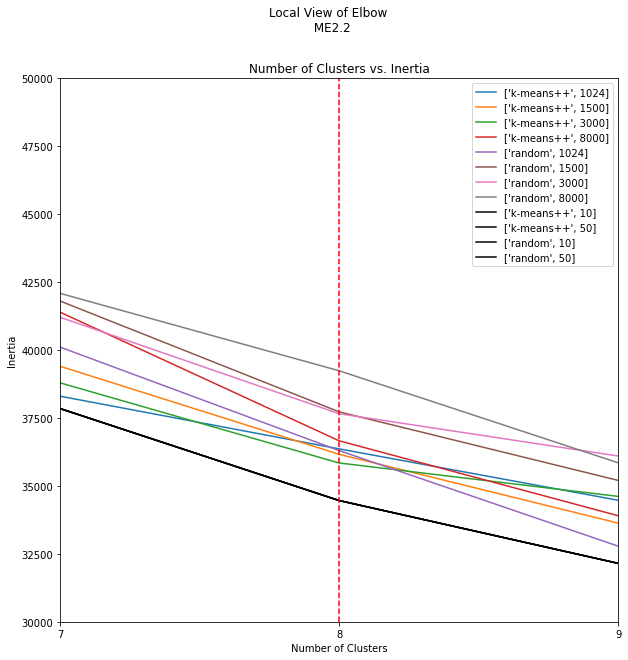

In [25]:
##Plot Number of clusters vs Inertia for kmeans and minibatch kmeans
plt.clf() 
plt.figure(figsize=(10,10))
##Plots all minibatch kmeans and regular kmeans
for init in inits:
    for batches in batch:
        plt.plot(kmini_inertias.n_clusters.loc[(kmini_inertias.iloc[:,1]==init) & (kmini_inertias.iloc[:,3]==batches)], kmini_inertias.inertia.loc[(kmini_inertias.iloc[:,1]==init) & (kmini_inertias.iloc[:,3]==batches)])
for init in inits:
    for n in n_inits:
        plt.plot(kmeans_inertia.n_clusters.loc[(kmeans_inertia.iloc[:,1]==init) & (kmeans_inertia.iloc[:,2]==n)], kmeans_inertia.inertia.loc[(kmeans_inertia.iloc[:,1]==init) & (kmeans_inertia.iloc[:,2]==n)],color="black")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.suptitle("Kmeans and MiniBatch KMeans \n ME2.1")
plt.title("Number of Clusters vs. Inertia")
plt.axvline(8, linestyle='--', color='r')
plt.show()

print("----------------------------------------------------------------------------------------------")

##plot a local figure around the elbow point

plt.figure(figsize=(10,10))
for init in inits:
    for batches in batch:
        plt.plot(kmini_inertias.n_clusters.loc[(kmini_inertias.iloc[:,1]==init) & (kmini_inertias.iloc[:,3]==batches)], kmini_inertias.inertia.loc[(kmini_inertias.iloc[:,1]==init) & (kmini_inertias.iloc[:,3]==batches)],label=[init,batches])
for init in inits:
    for n in n_inits:
        plt.plot(kmeans_inertia.n_clusters.loc[(kmeans_inertia.iloc[:,1]==init) & (kmeans_inertia.iloc[:,2]==n)], kmeans_inertia.inertia.loc[(kmeans_inertia.iloc[:,1]==init) & (kmeans_inertia.iloc[:,2]==n)],color="black",label=[init,n])
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.suptitle("Local View of Elbow \n ME2.2")
plt.title("Number of Clusters vs. Inertia")
plt.xlim(7,9)
plt.ylim(30000,50000)
plt.xticks([7,8,9],)
plt.axvline(8, linestyle='--', color='r')
plt.legend()
plt.show()

### Summarizing the results for the graphs Number of Clusters vs Inertia.
> The top graph (ME2.1) shows all of the inertia vs cluster values for all KMeans and MiniBatch KMeans hyper parameter tuning. The legend has been excluded due to the close proximity of all the curves; however, a glance at the top graph suggests that different hyperparameters in both algorithms doesn't appear to affect the inertia score significantly. For reference, the non-black lines are all from MiniBatch KMeans while the black line is represents all of the KMean hyperparameter tunings.  The KMeans inertia score does not vary by an amount that can be visually seen in this range. The cell below show the tuning outputs at 8 clusters for KMeans.  It can be seen that the inertia score only changes by roughly 1 at 8 clusters and around 100-200 at 28 clusters.  We are focused on the 8 cluster range as it is the "elbow" in the graph.

> The bottom graph (ME2.2) provides a local view around our selection of 8 clusters. A legend has been provided for this graph, but again the KMeans Algorithm tunings are all colored in black as it continues to not be visual in this range. It is not surprising that KMeans produces a lower Inertia score than MiniBatch, but it is encouraging to see how close MiniBatch is to the full KMeans.  Given the low Wall Time and the slightly better performance, we have chosen to go ahead with the KMeans algorithm using 8 clusters, init = k-means++ and n_init = 10.  Please note that init and n_init are the default settings.  Since all of the KMeans algorithms produced nearly identical results, we have decided to go with the default settings for those 2 parameters while setting n_clusters = 8.

In [26]:
kmeans_inertia.loc[(kmeans_inertia.n_clusters==8) | (kmeans_inertia.n_clusters==28)]

,n_clusters,init,n_init,inertia
28,8,k-means++,10,34462.327657
29,8,k-means++,50,34461.510118
30,8,random,10,34462.598030
31,8,random,50,34461.921317
108,28,k-means++,10,15511.447561
109,28,k-means++,50,15449.014519
110,28,random,10,15388.545074
111,28,random,50,15388.545074


> Showing KMeans algorithm and minute differences in inertia

## Modeling and Evaluation 3

> Since we are only clustering on 3 continuous variables, we have the benefit of being able to visualize our clusters more easily. There are 8 graphs for the KMeans clustering.  The first 3 rows of graphs represent a 2d slice of each feature plotted against the other.  The 1st and 2nd columns show a 180 degree rotation around the y-axis of the graphs. This allows us to see the clustering from the viewpoint of the minimum and maximum of the excluded feature.
The 4th row provides a 3d plot of the features to give the reader a better sense of how features interact in the clustering.


In [27]:
##K-means that had the best results
kmeans_full = KMeans(n_clusters=8,random_state=42)
kmeans_full.fit_transform(xx)
train_df['kmeans_8']=kmeans_mini.labels_


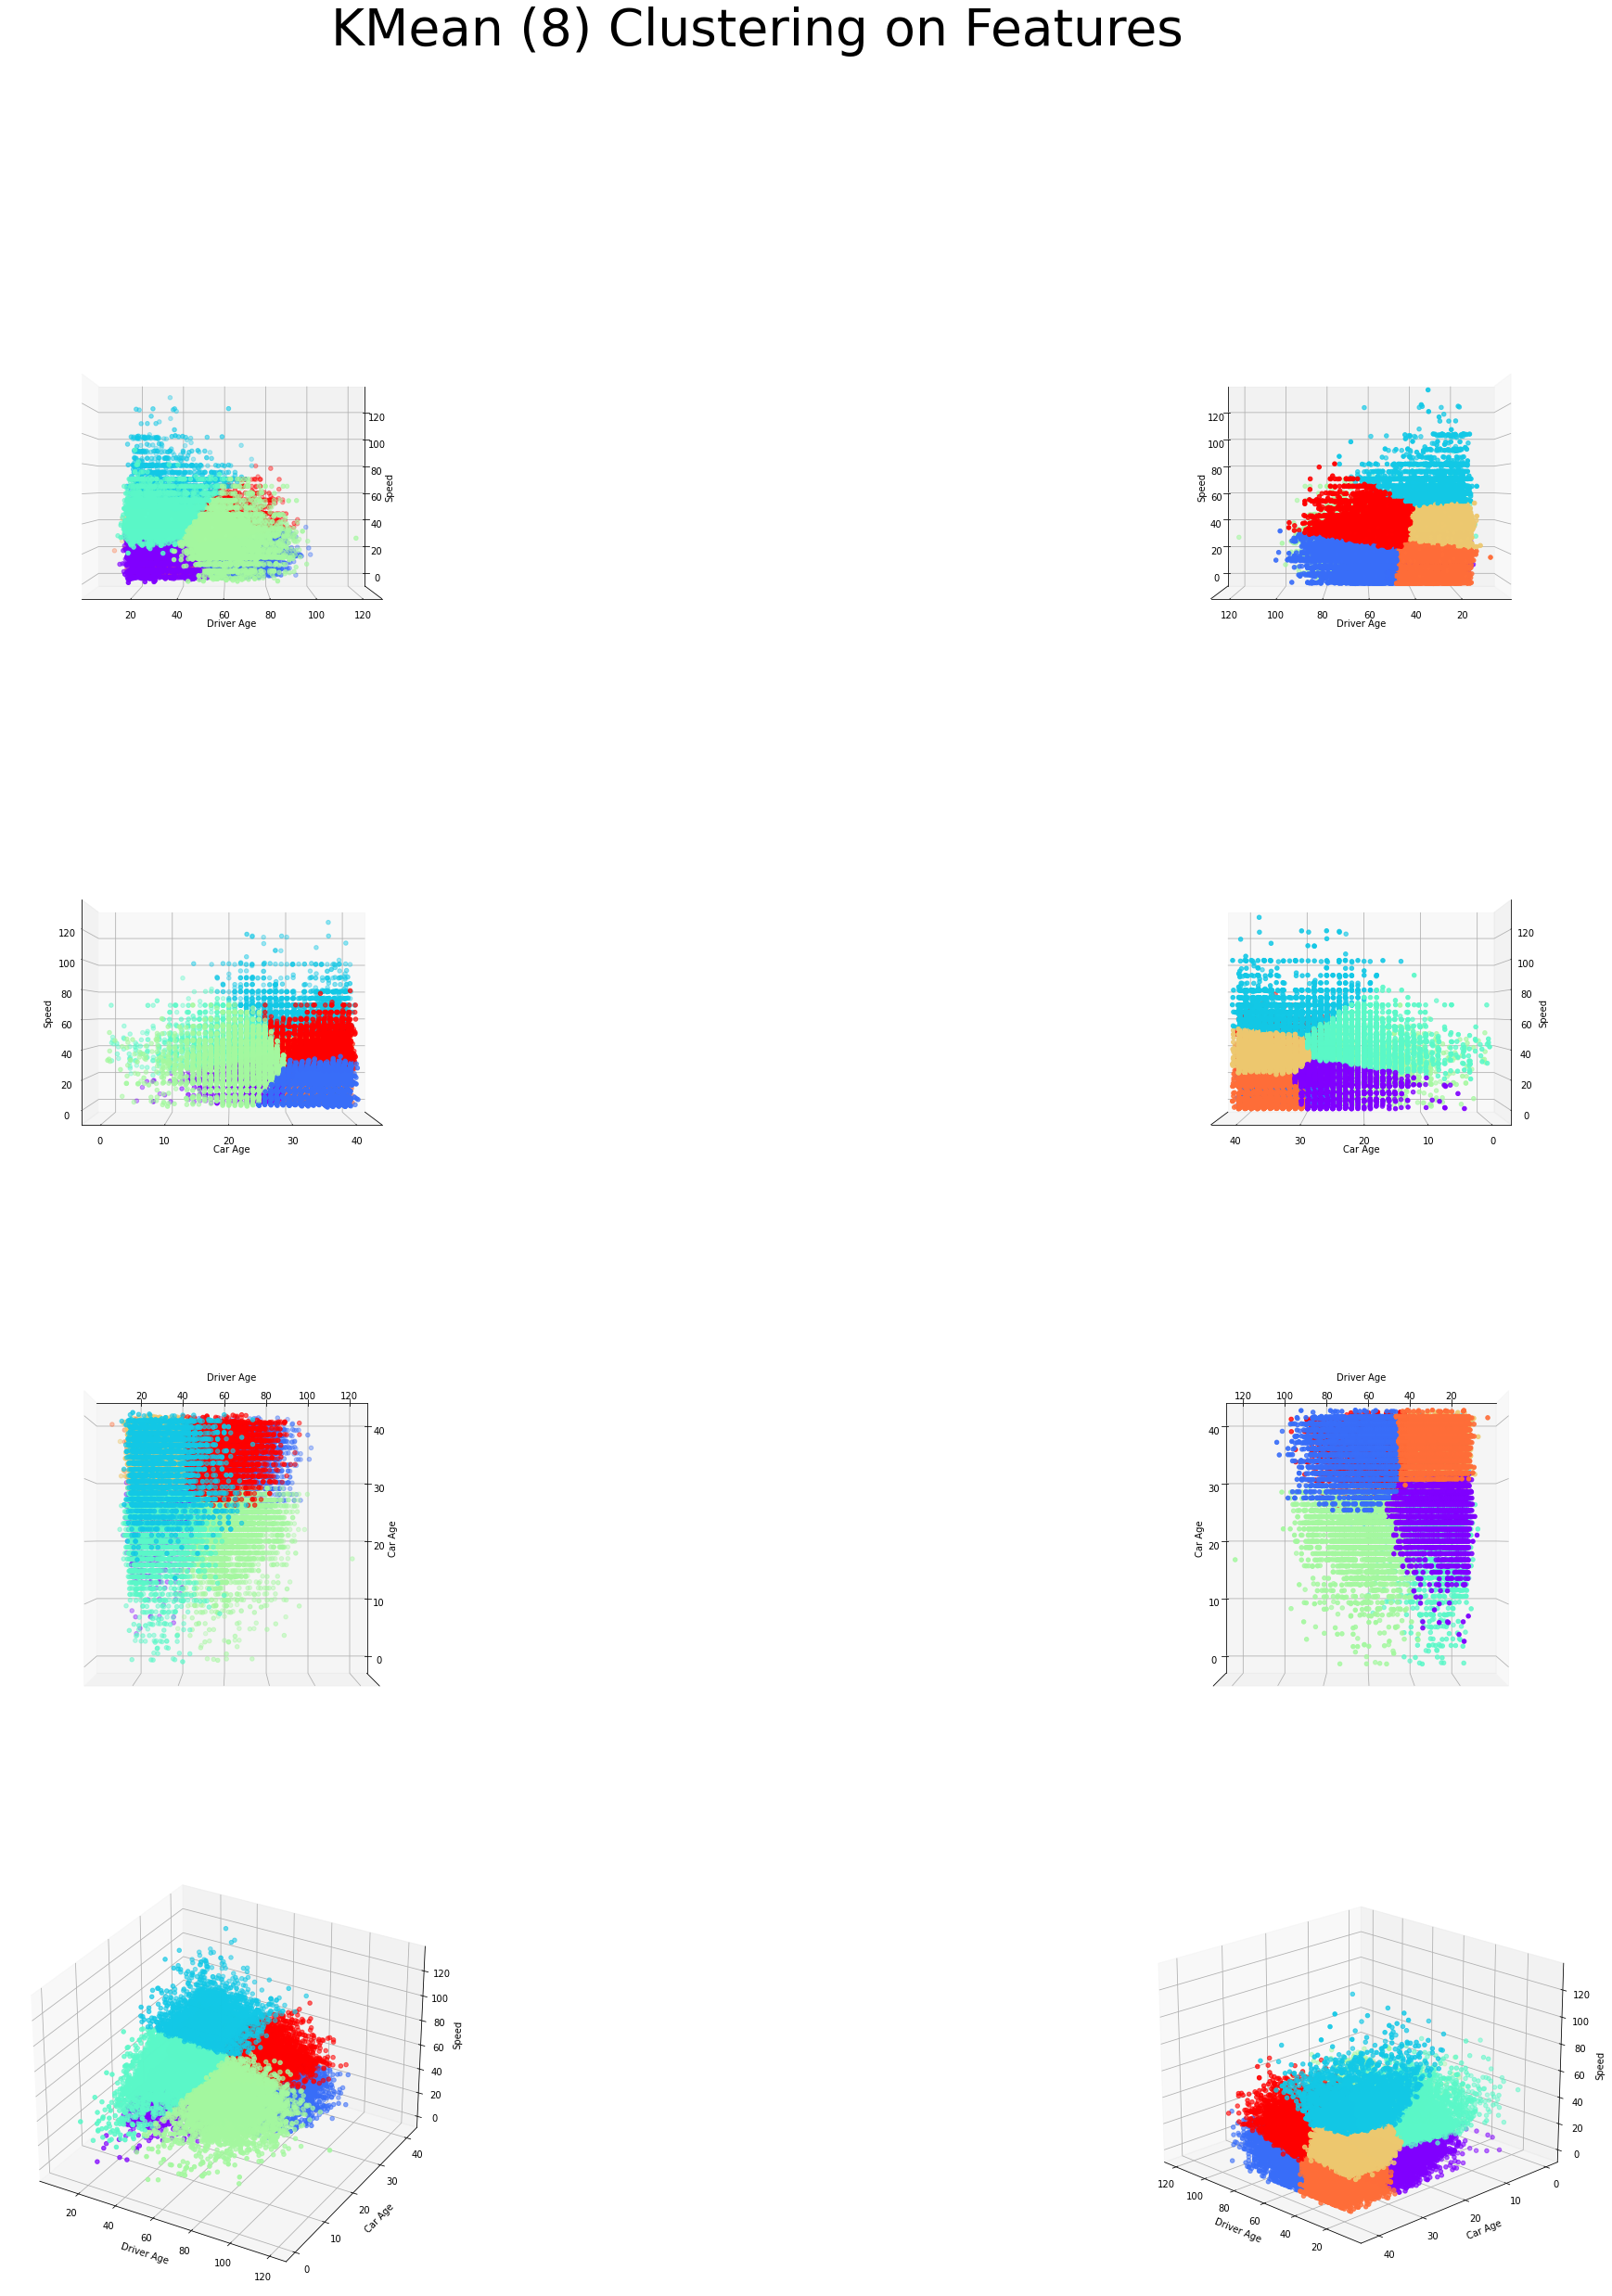

In [28]:
##3d plotting

## This does an inverse transform on the continuous variables to put them back to their original values for plotting

yy=pd.DataFrame(scaler.inverse_transform(xx[['age_im','mod_yearname_x']]),columns=['age_im','mod_yearname_x'])
yy['trav_sp_scaled']=speed_scaler.inverse_transform(xx[['trav_sp_scaled']])
yy.mod_yearname_x=yy.mod_yearname_x-1980
from mpl_toolkits import mplot3d

##Plot 1 Driver Age vs Speed

fig = plt.figure(figsize=(40,40))
fig.suptitle("KMean (8) Clustering on Features", fontsize=55)

ax = fig.add_subplot(4, 2, 1, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow)
ax.set_xlabel("Driver Age")
ax.set_ylabel("")
ax.set_zlabel("Speed")

ax.set_yticks([])
ax.view_init(azim=270,elev=0)

##Plot 2 Driver Age vs Speed


ax = fig.add_subplot(4, 2, 2, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow)
ax.set_xlabel("Driver Age")
ax.set_ylabel("")
ax.set_zlabel("Speed")

ax.set_yticks([])
ax.view_init(azim=90,elev=0)

##plot 3 Car Age vs Speed

ax = fig.add_subplot(4, 2, 3, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("")
ax.set_ylabel("Car Age")
ax.set_zlabel("Speed")

ax.set_xticks([])
ax.view_init(azim=0,elev=0)

##Plot 4 Car Age vs Speed

ax = fig.add_subplot(4, 2, 4, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("")
ax.set_ylabel("Car Age")
ax.set_zlabel("Speed")

ax.set_xticks([])
ax.view_init(azim=180,elev=0)



##plot 5

ax = fig.add_subplot(4, 2, 5, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("Driver Age")
ax.set_ylabel("Car Age")
ax.set_zlabel("")

ax.set_zticks([])
ax.view_init(azim=270,elev=90)

##plot 6

ax = fig.add_subplot(4, 2, 6, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("Driver Age")
ax.set_ylabel("Car Age")
ax.set_zlabel("")

ax.set_zticks([])
ax.view_init(azim=90,elev=270)

#plot 7
ax = fig.add_subplot(4, 2, 7, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("Driver Age")
ax.set_ylabel("Car Age")
ax.set_zlabel("Speed")


#plot 7
ax = fig.add_subplot(4, 2, 8, projection='3d')
ax.scatter3D(yy.iloc[:,0], yy.iloc[:,1], yy.iloc[:,2], c=kmeans_full.labels_, cmap=plt.cm.rainbow);
ax.set_xlabel("Driver Age")
ax.set_ylabel("Car Age")
ax.set_zlabel("Speed")
ax.view_init(azim=135,elev=20)
plt.show()

>

## Modeling and Evaluation 4

## KMeans Evaluation

> The first task for us in evaluating how well KMeans clusterering did is to see if there are any differences between the most occurring level of a feature in each cluster for each categorical variable.  
> The data with counts, top occurring level and number of levels per category is shown in Table 4.1.<br>
> However, Table 4.2 summarizes each most occurring level in each category for the training dataset.

In [58]:
##Print out top features for each cluster
holder=pd.DataFrame()
for clust in range(0,8):
    holder=pd.concat([holder,train_df.loc[train_df['kmeans_8']==clust].describe(include="object")])
print("\n\nTable 4.1\n\n")
holder



Table 4.1




,alchl_imname,body_type_binned,hour_binned,int_hwyname,intersection_binned,lgtcon_imname,maxsev_binned,maxsev_imname,pcrash1_imname,regionname,...,restraint_binned,sex_imname,speeding_status,urbanicityname,vnum_lanname,vsurcondname,vtrafconname,vtrafwayname,weather_binned,wkdy_imname
count,1524,1524,1524,1524,1524,1524,1524,1524,1524,1524,...,1524,1524,1524,1524,1524,1524,1524,1524,1524,1524
unique,2,12,4,2,3,6,2,5,15,4,...,4,2,3,2,9,9,12,8,6,7
top,No Alcohol Involved,1,Evening,No,Yes,Daylight,Not Fatal,No Apparent Injury,Turning Left,South,...,Full,Male,unknown,Urban,Not Reported,Dry,No Controls,"Two-Way, Not Divided",Clear,Friday
freq,1455,836,588,1501,893,1126,1412,776,624,854,...,1315,779,919,1205,503,1016,482,685,1110,274
count,1436,1436,1436,1436,1436,1436,1436,1436,1436,1436,...,1436,1436,1436,1436,1436,1436,1436,1436,1436,1436
unique,2,12,4,2,3,7,2,5,12,4,...,4,2,3,2,9,8,10,8,5,7
top,No Alcohol Involved,1,Evening,No,No,Daylight,Not Fatal,No Apparent Injury,Going Straight,South,...,Full,Male,unknown,Urban,Not Reported,Dry,No Controls,"Two-Way, Not Divided",Clear,Friday
freq,1354,775,506,1409,706,993,1292,740,1046,765,...,1156,801,1063,1085,491,1095,733,676,946,256
count,378,378,378,378,378,378,378,378,378,378,...,378,378,378,378,378,378,378,378,378,378
unique,2,12,4,2,3,6,2,5,9,4,...,4,2,3,2,8,6,8,7,5,7


> For example:  If we look at table 4.2, you will notice that each cluster has "No Alcohol Involved" as the most occurring level for alchl_imname; however hour_binned in Cluster 6 (Night) is different than every other cluster (Evening).  Scanning across table 4.2 shows that there are several features which have clusters that have varying top most occurring levels per feature. <br><br>
>Since we are looking for categories that we could easily know ahead of time to show a risk score, the ones that could be of use are body_type_binned, hour_binned, and wkdy_imname <br><br>
> We have kept a holdout test set in order to see how the clustering features compare to the training set.  Looking at Table 4.3 will show the results of the test set clustering using the KMeans hyperparameters.<br><br>
> We will summarize the ramifications of the results below:

In [61]:
##Print out top features for each cluster
holder=pd.DataFrame()
for clust in range(0,8):
    holder=pd.concat([holder,train_df.loc[train_df['kmeans_8']==clust].describe(include="object")])
print("\n\nTable 4.2 Train Dataset\n\n")
holder=holder.iloc[[2,6,10,14,18,22,26,30]]
holder.index=["Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5","Cluster 6","Cluster 7","Cluster 8"]
display(holder)

##This is the test set to see how well the most frequent in each category from the training set appears.
kmeans_full_test = KMeans(n_clusters=8,random_state=42)
test_df["trav_sp_scaled"] = test_pp_df.trav_sp_scaled.to_numpy()
xx_test=test_df[['mod_yearname_x','age_im','trav_sp_scaled']]
kmeans_full_test.fit_transform(xx_test)
test_df['kmeans_8']=kmeans_full_test.labels_
holder_test=pd.DataFrame()
for clust in range(0,8):
    holder_test=pd.concat([holder_test,test_df.loc[test_df['kmeans_8']==clust].describe(include="object")])
holder_test=holder_test.iloc[[2,6,10,14,18,22,26,30]]
holder_test.index=["Cluster 1 Test","Cluster 2 Test","Cluster 3 Test","Cluster 4 Test","Cluster 5 Test","Cluster 6 Test","Cluster 7 Test","Cluster 8 Test"]
print("\n\nTable 4.3 Test Dataset\n\n")
display(holder_test)



Table 4.2 Train Dataset




,alchl_imname,body_type_binned,hour_binned,int_hwyname,intersection_binned,lgtcon_imname,maxsev_binned,maxsev_imname,pcrash1_imname,regionname,...,restraint_binned,sex_imname,speeding_status,urbanicityname,vnum_lanname,vsurcondname,vtrafconname,vtrafwayname,weather_binned,wkdy_imname
Cluster 1,No Alcohol Involved,1,Evening,No,Yes,Daylight,Not Fatal,No Apparent Injury,Turning Left,South,...,Full,Male,unknown,Urban,Not Reported,Dry,No Controls,"Two-Way, Not Divided",Clear,Friday
Cluster 2,No Alcohol Involved,1,Evening,No,No,Daylight,Not Fatal,No Apparent Injury,Going Straight,South,...,Full,Male,unknown,Urban,Not Reported,Dry,No Controls,"Two-Way, Not Divided",Clear,Friday
Cluster 3,No Alcohol Involved,3,Evening,No,No,Daylight,Not Fatal,No Apparent Injury,Going Straight,South,...,Full,Male,unknown,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Thursday
Cluster 4,No Alcohol Involved,1,Evening,No,No,Daylight,Not Fatal,No Apparent Injury,Going Straight,South,...,Full,Male,unknown,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Friday
Cluster 5,No Alcohol Involved,1,Evening,No,Yes,Daylight,Not Fatal,No Apparent Injury,Turning Left,South,...,Full,Male,unknown,Urban,Not Reported,Dry,No Controls,"Two-Way, Not Divided",Clear,Friday
Cluster 6,No Alcohol Involved,1,Night,No,No,Daylight,Not Fatal,No Apparent Injury,Going Straight,South,...,Full,Male,unknown,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Saturday
Cluster 7,No Alcohol Involved,1,Evening,No,Yes,Daylight,Not Fatal,No Apparent Injury,Turning Left,South,...,Full,Male,unknown,Urban,Not Reported,Dry,No Controls,"Two-Way, Not Divided",Clear,Friday
Cluster 8,No Alcohol Involved,1,Evening,No,No,Daylight,Not Fatal,No Apparent Injury,Going Straight,South,...,Full,Male,unknown,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Friday




Table 4.3 Test Dataset




,alchl_imname,body_type_binned,hour_binned,int_hwyname,intersection_binned,lgtcon_imname,maxsev_binned,maxsev_imname,pcrash1_imname,regionname,...,restraint_binned,sex_imname,speeding_status,urbanicityname,vnum_lanname,vsurcondname,vtrafconname,vtrafwayname,weather_binned,wkdy_imname
Cluster 1 Test,No Alcohol Involved,1,Evening,No,Yes,Daylight,Not Fatal,No Apparent Injury,Going Straight,South,...,Full,Male,unknown,Urban,Not Reported,Dry,No Controls,"Two-Way, Not Divided",Clear,Friday
Cluster 2 Test,No Alcohol Involved,1,Evening,No,No,Daylight,Not Fatal,No Apparent Injury,Going Straight,South,...,Full,Male,unknown,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Tuesday
Cluster 3 Test,No Alcohol Involved,1,Evening,No,Yes,Daylight,Not Fatal,No Apparent Injury,Turning Left,South,...,Full,Male,unknown,Urban,Not Reported,Dry,No Controls,"Two-Way, Not Divided",Clear,Friday
Cluster 4 Test,No Alcohol Involved,1,Night,Yes,No,Daylight,Not Fatal,No Apparent Injury,Going Straight,South,...,Full,Male,not speeding,Urban,Two lanes,Dry,No Controls,"Two-Way, Divided, Positive Median Barrier",Clear,Sunday
Cluster 5 Test,No Alcohol Involved,1,Evening,No,No,Daylight,Not Fatal,No Apparent Injury,Going Straight,South,...,Full,Male,unknown,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Friday
Cluster 6 Test,No Alcohol Involved,1,Evening,No,No,Daylight,Not Fatal,No Apparent Injury,Going Straight,South,...,Full,Male,unknown,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Friday
Cluster 7 Test,No Alcohol Involved,1,Afternoon,No,Yes,Daylight,Not Fatal,No Apparent Injury,Turning Left,South,...,Full,Male,unknown,Urban,Not Reported,Dry,No Controls,"Two-Way, Not Divided",Clear,Thursday
Cluster 8 Test,No Alcohol Involved,1,Evening,No,No,Daylight,Not Fatal,No Apparent Injury,Going Straight,South,...,Full,Male,unknown,Urban,Two lanes,Dry,No Controls,"Two-Way, Not Divided",Clear,Friday


### Comparing the Training Set and Test Set Useful Features

1. The uniqueness of cluster 3 and body_type_binned did not show up in the test set.<br>
2. hour_binned also did not keep the uniqueness of cluster 6 in the test set.  The test set also changed around the most occurring levels for other clusters.<br>
3. wkdy_imname did a similar change as hour_binned in the test set.

>>(Reference Table 4.4 and 4.5)

In [67]:
print("\n\nTable 4.4 Training Set\n\n")
display(holder[['body_type_binned', 'hour_binned','wkdy_imname']])
print("\n\nTable 4.5 Test Set\n\n")
display(holder_test[['body_type_binned', 'hour_binned','wkdy_imname']])



Table 4.4 Training Set




,body_type_binned,hour_binned,wkdy_imname
Cluster 1,1,Evening,Friday
Cluster 2,1,Evening,Friday
Cluster 3,3,Evening,Thursday
Cluster 4,1,Evening,Friday
Cluster 5,1,Evening,Friday
Cluster 6,1,Night,Saturday
Cluster 7,1,Evening,Friday
Cluster 8,1,Evening,Friday




Table 4.5 Test Set




,body_type_binned,hour_binned,wkdy_imname
Cluster 1 Test,1,Evening,Friday
Cluster 2 Test,1,Evening,Tuesday
Cluster 3 Test,1,Evening,Friday
Cluster 4 Test,1,Night,Sunday
Cluster 5 Test,1,Evening,Friday
Cluster 6 Test,1,Evening,Friday
Cluster 7 Test,1,Afternoon,Thursday
Cluster 8 Test,1,Evening,Friday


#### KMeans Training and Test Summary
> The usefulness of this clustering is coming into question as it showed the variation in the training clusters did not generalize well to our test data.